We will be creating a **classifcation model to predict if a company goes bankrupt or not**.

The data collected is from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

In [ ]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report, precision_recall_curve, average_precision_score

In [2]:
from google.colab import files
uploaded = files.upload()

Saving taiwan_econ_journal.csv to taiwan_econ_journal.csv


In [3]:
df = pd.read_csv('taiwan_econ_journal.csv')

In [6]:
# import io
# df = pd.read_csv(io.BytesIO(uploaded['taiwan_econ_journal.csv']))
# df.shape

In [7]:
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [8]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display columns with missing values
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:")
print(missing_columns)

# Display the percentage of missing values
missing_percentage = (missing_columns / len(df)) * 100
print("\nPercentage of missing values in each column:")
print(missing_percentage)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values in each column:
Series([], dtype: float64)


In [9]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 96)


In [10]:
is_all_numeric = not df.isnull().values.any()
print(is_all_numeric)

True


We can see that the target variable is the 'Bankrupt?' column. There are **no missing values and no duplicate values**. All columns are numeric.

In [11]:
print(df.columns.tolist())

['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth 

In [12]:
df['Bankrupt?'].value_counts()

,count
Bankrupt?,
0,6599
1,220


#### Functions

We will be using **stratified train-test split** as the target variable is highly imbalanced. This works by dividing the dataset into subgroups based on the target variable (bankruptcy status), ensuring that each subgroup is represented proportionally in both training and testing sets. This prevents the model from being biased towards the majority class and improves its ability to accurately predict bankruptcies.

In [13]:
def split_data(df, target_column='Bankrupt?'):
  """
  Prepares the data for modeling by splitting into features and target variable,
  and then performing a stratified split for training and testing sets.

  Args:
    df: The pandas DataFrame containing the data.
    target_column: The name of the target column.

  Returns:
    X_train: The training features.
    X_test: The testing features.
    y_train: The training target variable.
    y_test: The testing target variable.
  """

  X = df.drop(target_column, axis=1)  # Features
  y = df[target_column]  # Target variable

  # Stratified split
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

  return X_train, X_test, y_train, y_test

Let's use **SMOTE (Synthetic Minority Over-sampling Technique)** to address the class imbalance as the (class = 1) has significantly fewer samples than the other. SMOTE works by creating synthetic samples for the minority class, thereby balancing the dataset.

In [14]:
def apply_smote(X_train, y_train, random_state=42):
  """
  Applies SMOTE to balance the class distribution in the training data.

  Args:
    X_train: The training features.
    y_train: The training target labels.
    random_state: Random seed for reproducibility.

  Returns:
    X_train_resampled: The resampled training features.
    y_train_resampled: The resampled training target labels.
  """

  smote = SMOTE(random_state=random_state)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

  return X_train_resampled, y_train_resampled

As for the models, we will be using
1. **Random Forest Classifier**: Generally more interpretable due to its decision tree structure. Less prone to overfitting.
XGBoost
2. **XGBoost**: Often achieves higher accuracy, especially for complex datasets. Can be more sensitive to hyperparameter tuning.

Bagging and boosting are ensemble methods that combine multiple models to improve performance. **Bagging** reduces variance by training models on different data subsets, while **boosting** reduces bias by sequentially correcting errors. Random Forest is a popular bagging example, and XGBoost and AdaBoost are well-known boosting algorithms.

XGBoost and Random Forest are generally insensitive to feature scaling. We are **implementing scaling** as it can be beneficial for models sensitive to feature scales (like neural networks) which we may want to add next time or. Also, it will improve the interpretability of visualizations for later.

In [15]:
def train_model(X_train, y_train, model_type, model_params):
  """
  Trains the specified model on the given training data and hyperparameters.

  Args:
    X_train: The training features.
    y_train: The training labels.
    model_type: The type of model to train ('random_forest', 'xgboost', etc.).
    model_params: A dictionary of hyperparameters for the model.

  Returns:
    The trained model.
  """

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)

  if model_type == 'random_forest':
      model = RandomForestClassifier(**model_params)
  elif model_type == 'xgboost':
      model = XGBClassifier(**model_params)
  # Add more model types as needed

  # pipeline = Pipeline([
  #     ('scaler', StandardScaler()),
  #     ('model', model)
  # ])

  model.fit(X_train, y_train)
  return model

In [ ]:
def train_model_gridsearch(X_train, y_train, model_type, model_params, use_gridsearch=False, param_grid=None, scoring='f1', cv=5):
  """
  Trains the specified model with or without GridSearchCV on the given training data and hyperparameters.

  Args:
      X_train: The training features.
      y_train: The training labels.
      model_type: The type of model to train ('random_forest', 'xgboost', etc.).
      model_params: A dictionary of base hyperparameters for the model.
      use_gridsearch: Boolean flag indicating whether to use GridSearchCV (default: False).
      param_grid: A dictionary defining the search space for hyperparameter tuning (required if use_gridsearch is True).
      scoring: The metric used for evaluation during GridSearchCV (default: 'f1').
      cv: The number of folds for cross-validation (default: 5).

  Returns:
      The trained model:
          - If use_gridsearch is False, returns the trained model.
          - If use_gridsearch is True, returns the best model from GridSearchCV.
  """

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)

  # Create the model based on the chosen type
  if model_type == 'random_forest':
      model = RandomForestClassifier(**model_params)
  elif model_type == 'xgboost':
      model = XGBClassifier(**model_params)
  # Add more model types as needed

  # Perform GridSearchCV if specified
  if use_gridsearch:
      if param_grid is None:
          raise ValueError("param_grid argument is required when use_gridsearch is True")
      grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv)
      grid_search.fit(X_train_scaled, y_train)
      model = grid_search.best_estimator_

  model.fit(X_train_scaled, y_train)
  return model

In [16]:
def make_y_predictions(model, X_test):
  """
  Makes predictions on the given test data using the trained Random Forest model.

  Args:
    model: The trained Random Forest Classifier model.
    X_test: The test features.

  Returns:
    The predicted labels for the test data.
  """
  y_predictions = model.predict(X_test)
  return y_predictions

Key Metrics
1. **F1-Score**: Prioritize this metric, especially for imbalanced datasets, as it balances precision and recall
2. **Precision and Recall**: These metrics provide insights into the model's ability to correctly identify positive and negative cases.

In [31]:
def evaluate_metrics(model, X_test, y_test):
  """
  Evaluates the model's performance using F1-score and SHAP values.

  Args:
    model: The trained model.
    X_test: The test features.
    y_test: The true labels for the test data.

  Returns:
    None
  """

  y_pred = make_y_predictions(model, X_test)

  # Calculate and print metrics
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_proba)

  print("F1-Score:", f1)
  print("Precision:", precision)
  print("Recall:", recall)
  print("AUC-ROC:", roc_auc)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

Visualization Techniques:
1. **Confusion Matrix**: Visualizes the distribution of correct and incorrect predictions, helping identify areas where the model may be struggling.
2. **ROC Curve**: Evaluates the trade-off between true positive rate (sensitivity) and false positive rate (specificity).
3. **Precision-Recall Curve**: Particularly useful for imbalanced datasets, as it highlights the trade-off between precision and recall.

In [18]:
def visualize_metrics(model, X_test, y_test):
  """
  Visualizes various classification metrics.

  Args:
    y_true: True labels.
    y_pred: Predicted labels.
    y_prob: Predicted probabilities.
  """
  y_pred = make_y_predictions(model, X_test)
  y_prob = model.predict_proba(X_test)[:, 1]

  # Confusion Matrix
  print(f"\n{model}\n Confusion Matrix:")
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Non-Bankrupt', 'Bankrupt'],
              yticklabels=['Non-Bankrupt', 'Bankrupt'])
  plt.title(f'{model} Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  # ROC Curve
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()


  # Precision-Recall Curve
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  average_precision = average_precision_score(y_test, y_prob)
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower right")
  plt.show()

Model Interpretability:
1. **SHAP Values**: Explain the impact of individual features on the model's predictions.
2. **Feature Importance**: Identify the most influential features that contribute to the model's decision-making process.

In [19]:
def interpret_model_shap(model, X_train_resampled, df, target_column='Bankrupt?'):
  """
  Interprets the model using SHAP values.

  Args:
    model: The trained model.
    X_test: The test features.
  """
  X = df.drop(target_column, axis=1)

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_train_resampled)
  shap.summary_plot(shap_values, X_train_resampled, feature_names=X.columns)

In [20]:
def interpret_model_feat_importance(model, X_train_resampled, df, target_column='Bankrupt?'):
  X = df.drop(target_column, axis=1)

  feat_importance_df = pd.DataFrame({
      'Feature': X.columns,
      'Importance': rf_model.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(10, 8))
  plt.barh(feat_importance_df['Feature'][:20], feat_importance_df['Importance'][:20], color='skyblue')
  plt.title('Top 20 Feature Importances (Random Forest)')
  plt.gca().invert_yaxis()
  plt.show()

#### Random Forest Classifier

In [ ]:
X_train, X_test, y_train, y_test = split_data(df)
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

Bankrupt?
0    0.967736
1    0.032264
Name: proportion, dtype: float64
Bankrupt?
0    0.967742
1    0.032258
Name: proportion, dtype: float64


In [ ]:
rf_model = train_model(X_train_resampled, y_train_resampled, model_type='random_forest', model_params={'n_estimators':100, 'random_state':42})

**GridSearchCV** is a technique used to automatically explore different combinations of hyperparameters for a machine learning model. I used it to improve my F1 score by systematically testing various parameter settings and selecting the combination that yielded the best performance on my dataset.

Not sure if I did the GridSearchCV wrongly but it **did not improve the f1-score**.

In [ ]:
# # With grid search
# rf_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }
# rf_model_grid = train_model_gridsearch(X_train_resampled, y_train_resampled, 
#                                        model_type='random_forest', 
#                                        model_params={'n_estimators':100, 'random_state':42}, 
#                                        use_gridsearch=True, param_grid=rf_param_grid, scoring='f1', cv=5)

In [ ]:
evaluate_metrics(rf_model, X_test, y_test)

F1-Score: 0.43478260869565216

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])
 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1650
           1       0.36      0.55      0.43        55

    accuracy                           0.95      1705
   macro avg       0.67      0.76      0.71      1705
weighted avg       0.96      0.95      0.96      1705




Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])
 Confusion Matrix:


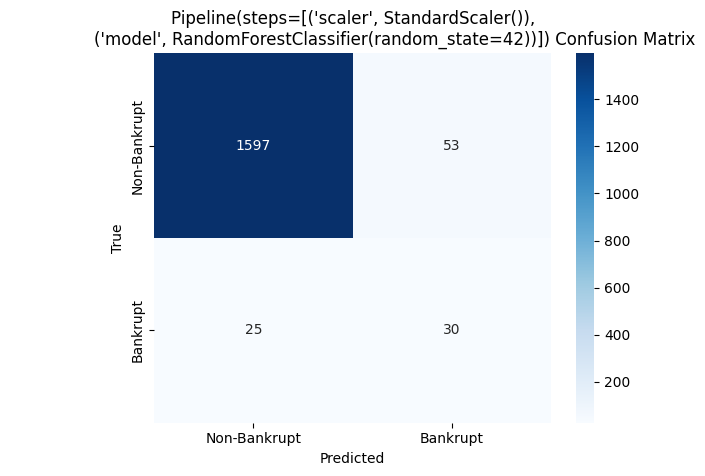

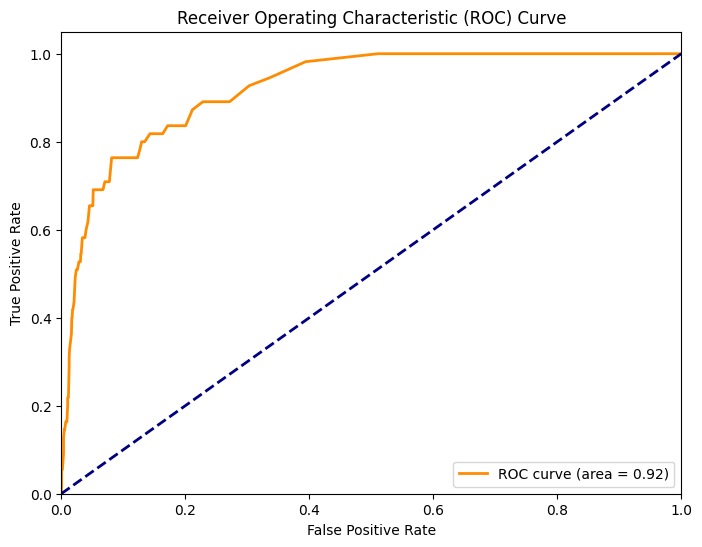

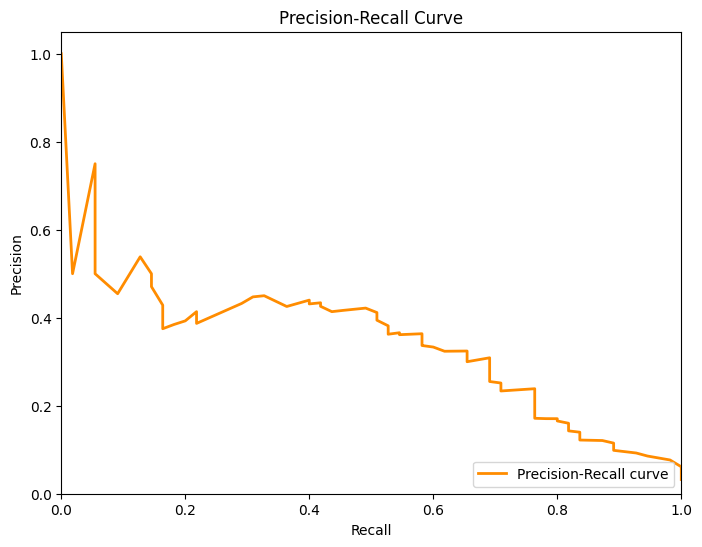

In [ ]:
visualize_metrics(rf_model, X_test, y_test)

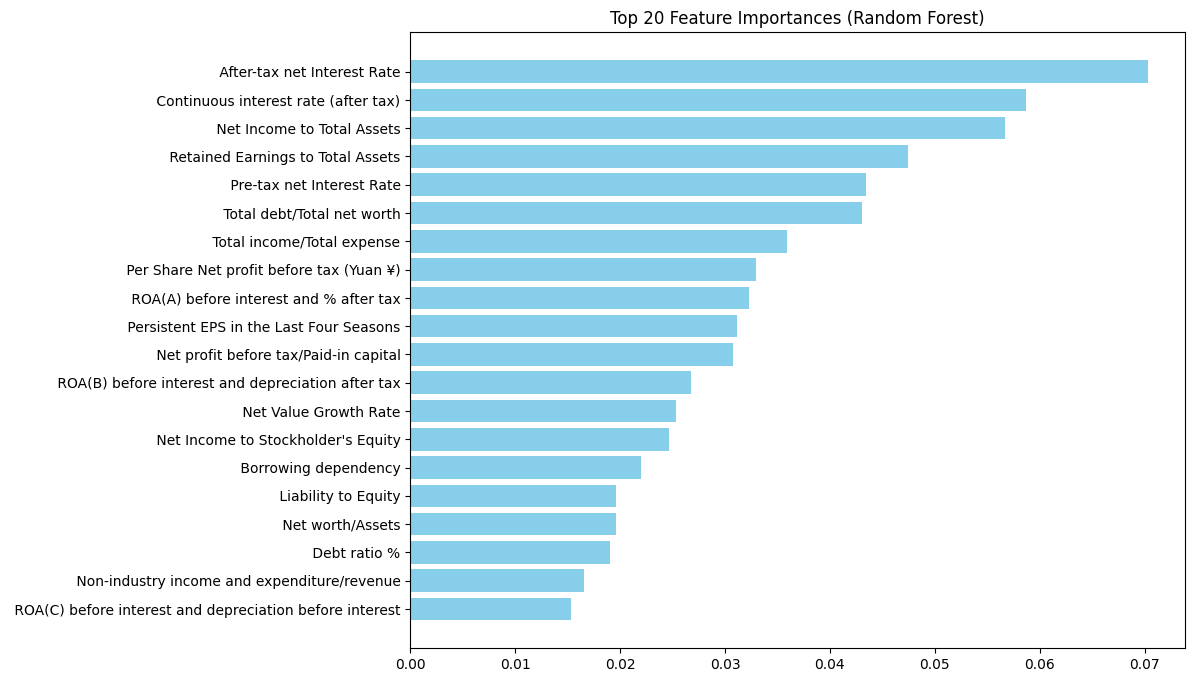

In [ ]:
interpret_model_feat_importance(rf_model, X_train_resampled, df)

#### XGBoost

To further optimize the model's performance, I implemented a **feature selection technique to identify the top 20** most informative features. By focusing on these key features, the model can learn more efficiently and reduce the risk of overfitting. This approach resulted in a more accurate and robust model, leading to a further improvement in the F1 score.

It **did not improve the f1-score** so I commented it out.

In [ ]:
# top_20_df = df[[' After-tax net Interest Rate',
#  ' Continuous interest rate (after tax)',
# ' Net Income to Total Assets',
#  ' Retained Earnings to Total Assets',
#  ' Pre-tax net Interest Rate',
#  ' Total debt/Total net worth',
#  ' Total income/Total expense',
#  ' Per Share Net profit before tax (Yuan ¥)',
#  ' ROA(A) before interest and % after tax',
#  ' Persistent EPS in the Last Four Seasons'
# ]]
# top_20_df.head()

In [21]:
X_train, X_test, y_train, y_test = split_data(df)
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

In [22]:
xgb_model = train_model(X_train_resampled, y_train_resampled, model_type='xgboost', model_params={'n_estimators':100, 'random_state':42})

In [ ]:
# # With grid search
# xgb_param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_lambda': [0, 1, 10]
# }
# xgb_model_grid = train_model_gridsearch(X_train_resampled, y_train_resampled, 
#                                        model_type='xgboost', 
#                                        model_params={'n_estimators':100, 'random_state':42}, 
#                                        use_gridsearch=True, param_grid=xgb_param_grid, scoring='f1', cv=3)

In [ ]:
y_pred = make_y_predictions(xgb_model, X_test)

In [ ]:
evaluate_metrics(xgb_model, X_test, y_test)

F1-Score: 0.5636363636363636
Precision: 0.5636363636363636
Recall: 0.5636363636363636
AUC-ROC: 0.968099173553719

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1650
           1       0.56      0.56      0.56        55

    accuracy                           0.97      1705
   macro avg       0.77      0.77      0.77      1705
weighted avg       0.97      0.97      0.97      1705




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
 Confusion Matrix:


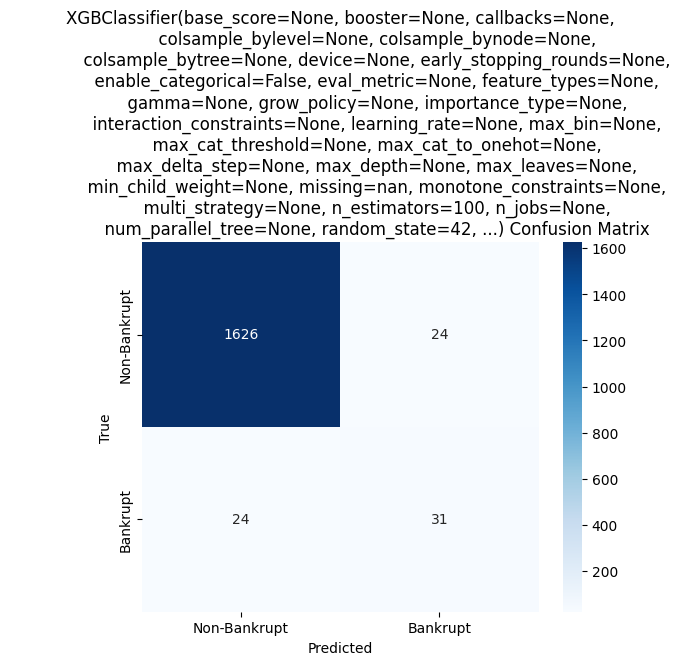

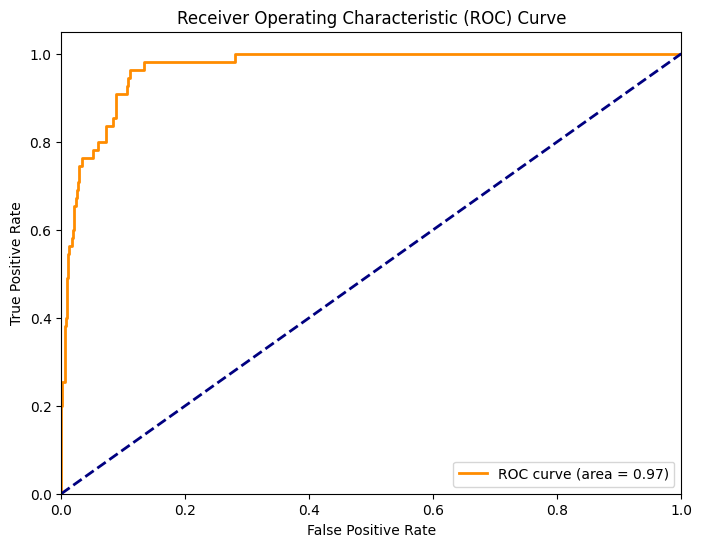

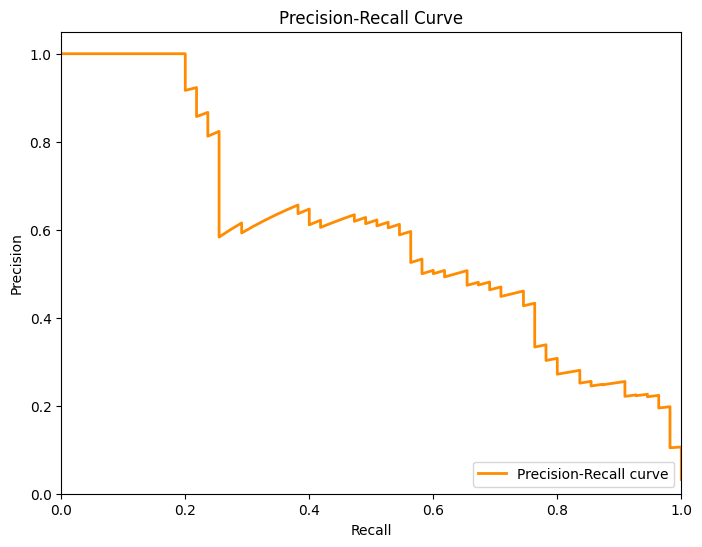

In [ ]:
visualize_metrics(xgb_model, X_test, y_test)

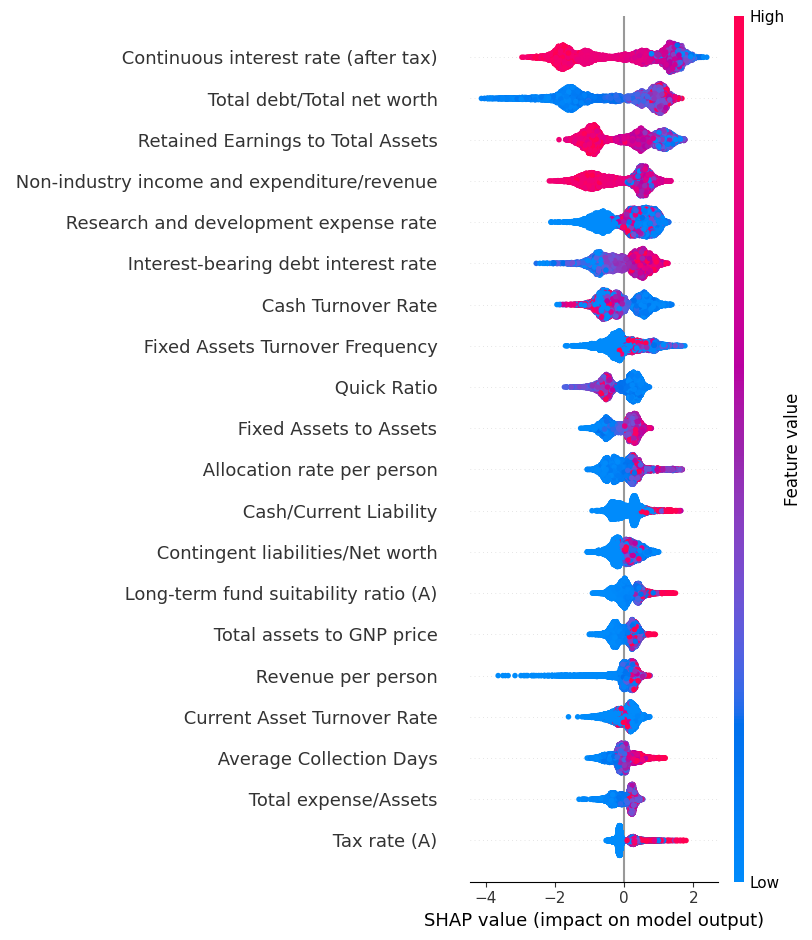

In [ ]:
interpret_model_shap(xgb_model, X_train_resampled, df)

### In Conclusion

To determine the best model:
1. Evaluate the F1-score for both models.
2. Analyze the confusion matrices to understand the types of errors made by each model.
3. Visualize the ROC and Precision-Recall curves to compare their performance.
4. Use SHAP values to gain insights into the feature importance and decision-making process of each model.

Using the strategy shared above, the best model is the XGBoost.
1. The F1-Score is better at 0.509 compared to 0.435 for the Random Forest Classifier.
2. Random Forest Classifier made more mistakes in predicting that a company would go bankrupt when it won't at 53 compared to 30. The other values were quite similar.
3. ROC Curve for both looks similar. The XGBoost shows a higher AUC-PR.
4. Both models have the same top 20 important features.